### SECTION C- Task Detail: Visualizations

#### Load Data

In [10]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Connect to the SQLite database
conn = sqlite3.connect('cleaned_database.db')

# Load data from the database into pandas DataFrames
calls = pd.read_sql_query("SELECT * FROM calls", conn)
queues = pd.read_sql_query("SELECT * FROM queues", conn)
services = pd.read_sql_query("SELECT * FROM services", conn)
counters = pd.read_sql_query("SELECT * FROM counters", conn)
users = pd.read_sql_query("SELECT * FROM users", conn)

# Close the database connection
conn.close()


#### Calculate Key metrics

In [11]:
# Merge calls and queues on queue_id to calculate metrics
calls_queues = pd.merge(calls, queues, left_on='queue_id', right_on='id', suffixes=('_call', '_queue'))

# Ensure datetime columns are in the correct format
calls_queues['created_at_call'] = pd.to_datetime(calls_queues['created_at_call'])
calls_queues['updated_at_call'] = pd.to_datetime(calls_queues['updated_at_call'])
calls_queues['created_at_queue'] = pd.to_datetime(calls_queues['created_at_queue'])

# Calculate waiting time, service time and turn-around time
calls_queues['waiting_time'] = (calls_queues['created_at_call'] - calls_queues['created_at_queue']).dt.total_seconds()
calls_queues['service_time'] = (calls_queues['updated_at_call'] - calls_queues['created_at_call']).dt.total_seconds()
calls_queues['turn_around_time'] = (calls_queues['updated_at_call'] - calls_queues['created_at_queue']).dt.total_seconds()

calls_queues[['queue_id', 'waiting_time', 'service_time', 'turn_around_time']].head()

,queue_id,waiting_time,service_time,turn_around_time
0,45,873.0,13.0,886.0
1,46,819.0,8.0,827.0
2,47,617.0,4.0,621.0
3,50,29.0,62.0,91.0
4,51,1997.0,6.0,2003.0


#### Calculate Statistics

In [12]:
# Calculate descriptive statistics for waiting time, service time, and turn-around time
descriptive_stats = {
    'waiting_time': {
        'mean': calls_queues['waiting_time'].mean(),
        'median': calls_queues['waiting_time'].median(),
        'std': calls_queues['waiting_time'].std()
    },
    'service_time': {
        'mean': calls_queues['service_time'].mean(),
        'median': calls_queues['service_time'].median(),
        'std': calls_queues['service_time'].std()
    },
    'turn_around_time': {
        'mean': calls_queues['turn_around_time'].mean(),
        'median': calls_queues['turn_around_time'].median(),
        'std': calls_queues['turn_around_time'].std()
    }
}

# Display the descriptive statistics
print("Descriptive Statistics:")
for metric, stats in descriptive_stats.items():
    print(f"\n{metric.capitalize()}:")
    print(f"  Mean: {stats['mean']}")
    print(f"  Median: {stats['median']}")
    print(f"  Standard Deviation: {stats['std']}")


Descriptive Statistics:

Waiting_time:
  Mean: 4174.621848739495
  Median: 3688.0000000000005
  Standard Deviation: 2952.797983092017

Service_time:
  Mean: 697.4468396054074
  Median: 637.0
  Standard Deviation: 635.9298685412648

Turn_around_time:
  Mean: 4872.068688344903
  Median: 4363.0
  Standard Deviation: 3066.2194361320758


#### Histograms for key metrics

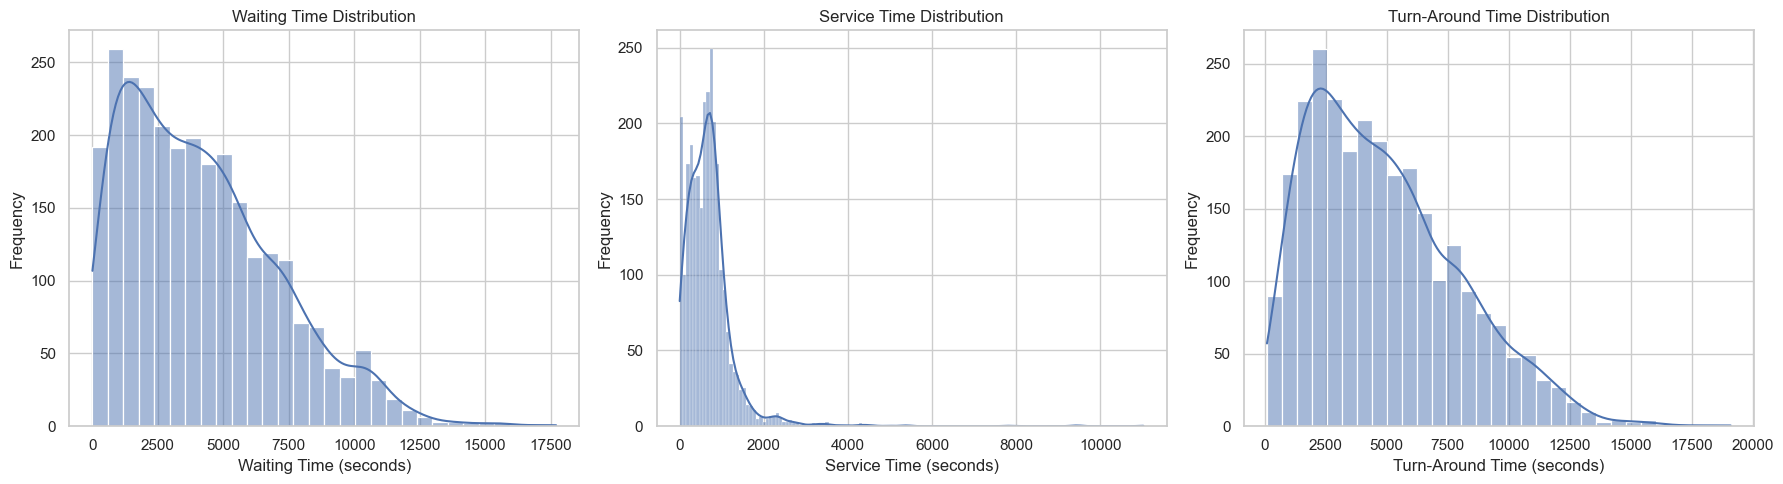

In [15]:
sns.set_theme(style="whitegrid")

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(calls_queues['waiting_time'], kde=True, ax=axs[0])
axs[0].set_title('Waiting Time Distribution')
axs[0].set_xlabel('Waiting Time (seconds)')
axs[0].set_ylabel('Frequency')

sns.histplot(calls_queues['service_time'], kde=True, ax=axs[1])
axs[1].set_title('Service Time Distribution')
axs[1].set_xlabel('Service Time (seconds)')
axs[1].set_ylabel('Frequency')

sns.histplot(calls_queues['turn_around_time'], kde=True, ax=axs[2])
axs[2].set_title('Turn-Around Time Distribution')
axs[2].set_xlabel('Turn-Around Time (seconds)')
axs[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


#### Box Plots for Key Metrics

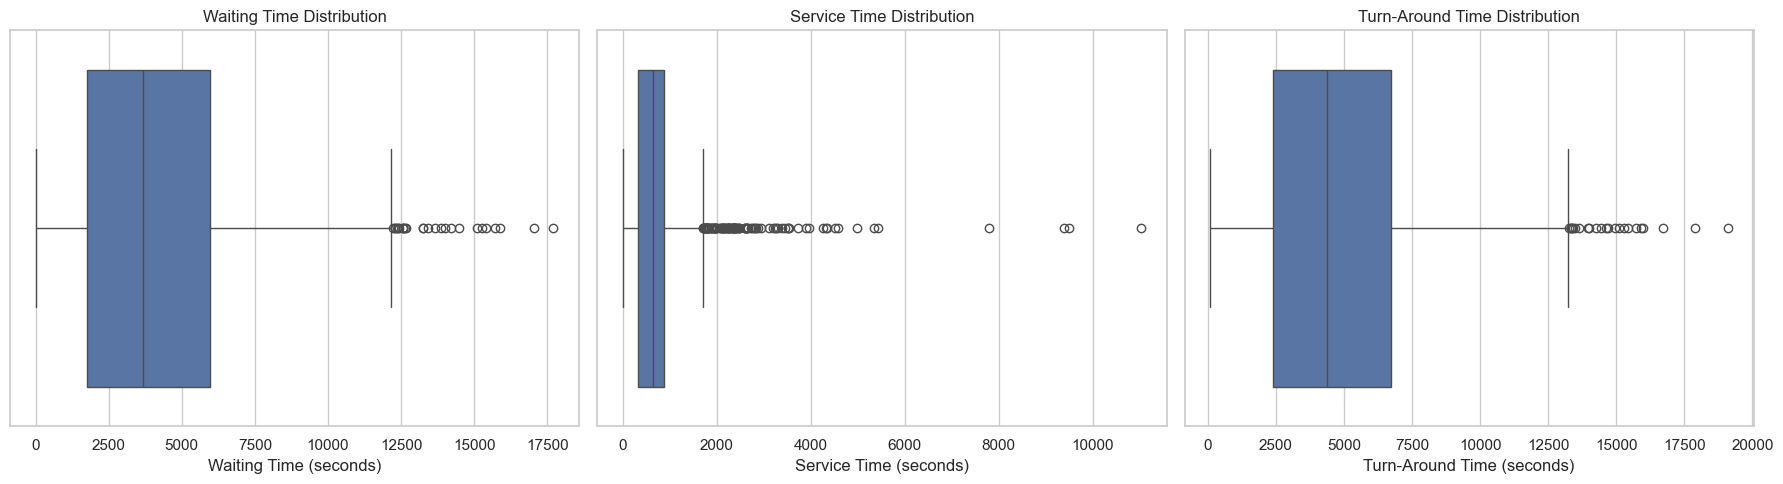

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(x=calls_queues['waiting_time'], ax=axs[0])
axs[0].set_title('Waiting Time Distribution')
axs[0].set_xlabel('Waiting Time (seconds)')

sns.boxplot(x=calls_queues['service_time'], ax=axs[1])
axs[1].set_title('Service Time Distribution')
axs[1].set_xlabel('Service Time (seconds)')

sns.boxplot(x=calls_queues['turn_around_time'], ax=axs[2])
axs[2].set_title('Turn-Around Time Distribution')
axs[2].set_xlabel('Turn-Around Time (seconds)')

plt.tight_layout()
plt.show()


#### Calculate Daily Metrics

In [17]:
calls_queues['date'] = calls_queues['created_at_queue'].dt.date
daily_metrics = calls_queues.groupby('date').agg({
    'queue_id': 'count',
    'waiting_time': 'mean',
    'service_time': 'mean',
    'turn_around_time': 'mean'
}).reset_index()

daily_metrics.rename(columns={'queue_id': 'customers_served'}, inplace=True)

daily_metrics.head()

,date,customers_served,waiting_time,service_time,turn_around_time
0,2024-01-25,6,1066.333333,21.166667,1087.500000
1,2024-01-26,79,6046.101266,703.379747,6749.481013
2,2024-01-28,185,4908.827027,877.502703,5786.329730
3,2024-01-29,122,5282.991803,542.622951,5825.614754
4,2024-01-30,144,6756.187500,696.347222,7452.534722


#### Line Plots for Trends Over Time

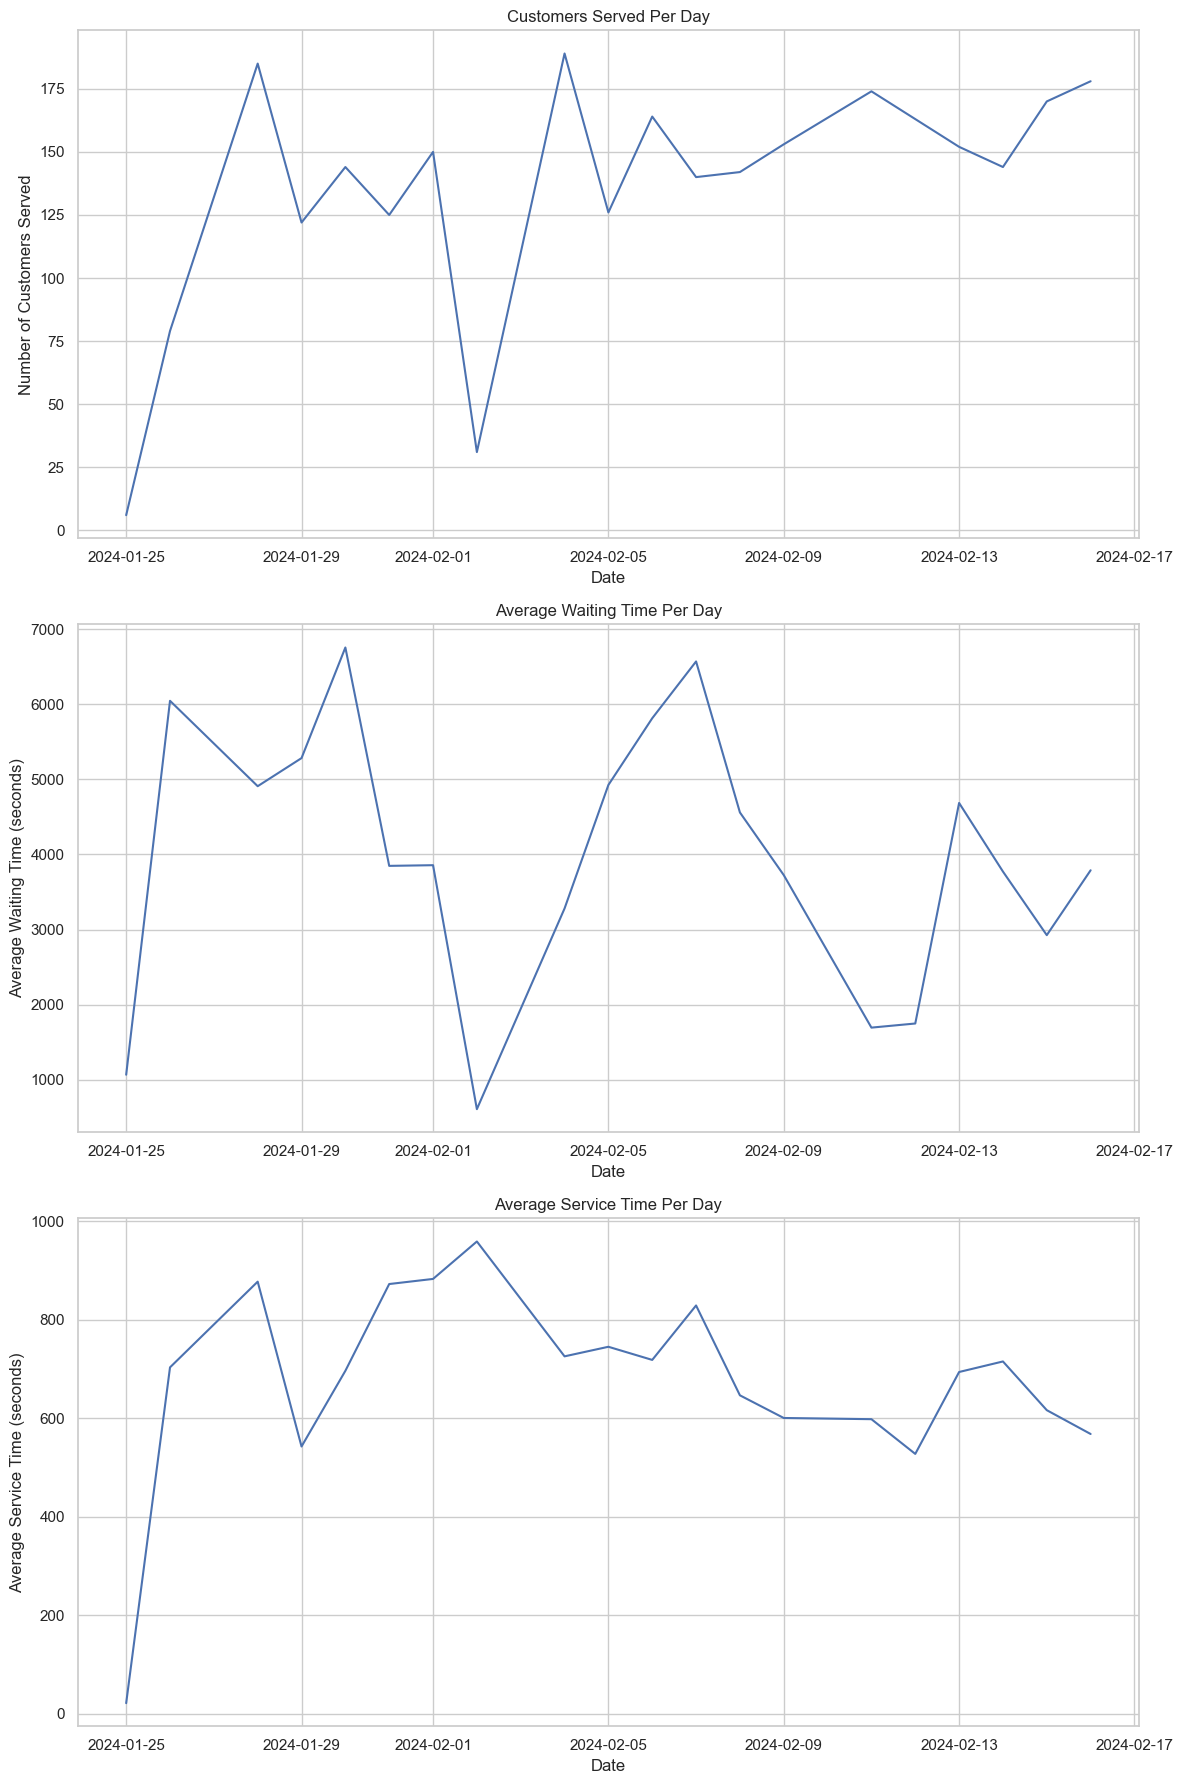

In [18]:
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

sns.lineplot(data=daily_metrics, x='date', y='customers_served', ax=axs[0])
axs[0].set_title('Customers Served Per Day')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Number of Customers Served')

sns.lineplot(data=daily_metrics, x='date', y='waiting_time', ax=axs[1])
axs[1].set_title('Average Waiting Time Per Day')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Average Waiting Time (seconds)')

sns.lineplot(data=daily_metrics, x='date', y='service_time', ax=axs[2])
axs[2].set_title('Average Service Time Per Day')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Average Service Time (seconds)')

plt.tight_layout()
plt.show()
